# Inference Workflow

After training the model, the next step is inference—using the trained model to make predictions on new, unseen data.

## What is inference?

Inference means applying the model to input data and getting outputs (predictions).

For our seismic workflow, this means:

Feeding waveform segments into the model.

Getting predicted probabilities for each class (e.g., P-wave, S-wave, Noise).

Converting those probabilities into phase picks or labels.

## What happens in this section?

Prepare the data for inference.
Run the model on the data 

Interpret the output:

Visualize predicted probabilities.
Extract phase arrival times.


In [1]:

import os
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import json
import time

import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from scipy.signal import find_peaks


In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the device
model = sbm.PhaseNet(phases="PSN")
model.to(device)

Using device: cpu


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [3]:
# Load the data
print("Loading data...")
data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")

Loading data...


In [4]:
print(f"Sampled dataset size: {len(data)}")

Sampled dataset size: 1139808


In [5]:
# Load the data
train, dev, test = data.train_dev_test()

In [6]:

print("Train:", train)
print("Dev:", dev)
print("Test:", test)


Train: OKLA_1Mil_120s_Ver_3 - 797268 traces
Dev: OKLA_1Mil_120s_Ver_3 - 171351 traces
Test: OKLA_1Mil_120s_Ver_3 - 171189 traces


In [7]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [8]:

# Load the model
def load_model(model, model_filename, device):
    """
    Load the model from a file.
    Args:
        model: Model architecture to load the weights into.
        model_filename: Filename of the saved model.
        device: Device to load the model onto.
    Returns:
        Model with loaded weights.
    """
    model.load_state_dict(torch.load(model_filename, map_location=device))
    model.to(device)
    return model

# Load the final model
model_filename = "../scripts/PNET_ModelTraining_64_0.01_20Percent_Example/best_model.pth"
model = load_model(model, model_filename, device)

In [9]:

# Create the output folder
output_folder = "single_examples"
os.makedirs(output_folder, exist_ok=True)


In [10]:

# Parameters for peak detection
sampling_rate = 100  # Samples per second (100 Hz)
height = 0.5
distance = 100

In [14]:
# Run the prediction 100 times
for i in range(1, 5):
#for i in range(1, 101):
    # Visualizing Predictions
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(5, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("Dataset Ground Truth", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals
    residual_p_arrival_times = p_arrival_times - y_p_arrival_times[:, np.newaxis]
    residual_s_arrival_times = s_arrival_times - y_s_arrival_times[:, np.newaxis]

    # Plot the probability distributions and the detected peaks
    axs[4].plot(p_prob, color=label_colors[0], linewidth=1.5,label='P-phase')
    axs[4].plot(p_peaks, p_prob[p_peaks], 'x', label='Detected P Arrival', color='red')
    axs[4].plot(s_prob, color=label_colors[1], linewidth=1.5,label='S-phase')
    axs[4].plot(s_peaks, s_prob[s_peaks], 'x', label='Detected S Arrival', color='blue')
    axs[4].set_title('Model Prediction', fontsize=12, fontweight='bold')
    axs[4].set_ylim(0,1.1)
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].set_ylabel('Probability', fontsize=10)
    axs[4].legend()

    # Improve x-axis visibility
    axs[4].set_xlabel("Time (samples)", fontsize=11, fontweight='bold')
    axs[4].tick_params(axis='x', labelsize=10)

    #plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"Prediction{i}_Predictions_Plot.png")
    plt.savefig(plot_filename)
    #plt.show()
    plt.close(fig)

    # Save the results to a text file
    results_filename = os.path.join(output_folder, f"Prediction{i}_Example_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Ground Truth P arrival times: {y_p_arrival_times}\n")
        f.write(f"Ground Truth S arrival times: {y_s_arrival_times}\n")
        f.write(f"Predicted P arrival times: {p_arrival_times}\n")
        f.write(f"Predicted S arrival times: {s_arrival_times}\n")
        f.write(f"Residual P arrival times: {residual_p_arrival_times}\n")
        f.write(f"Residual S arrival times: {residual_s_arrival_times}\n")

    # Save the parameters to a text file
    parameters_filename = os.path.join(output_folder, f"Prediction{i}_Example_Parameters.txt")
    with open(parameters_filename, "w") as f:
        f.write(f"Sampling Rate: {sampling_rate}\n")
        f.write(f"Height Parameter: {height}\n")
        f.write(f"Distance Parameter: {distance}\n")


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Total ground truth P peaks: 158
Total ground truth S peaks: 156
Total P-phase residuals under 0.6s: 144
Total S-phase residuals under 0.6s: 141
P-phase Residuals: Mean = -0.1881, Std = 2.2037
Total detected P picks: 149


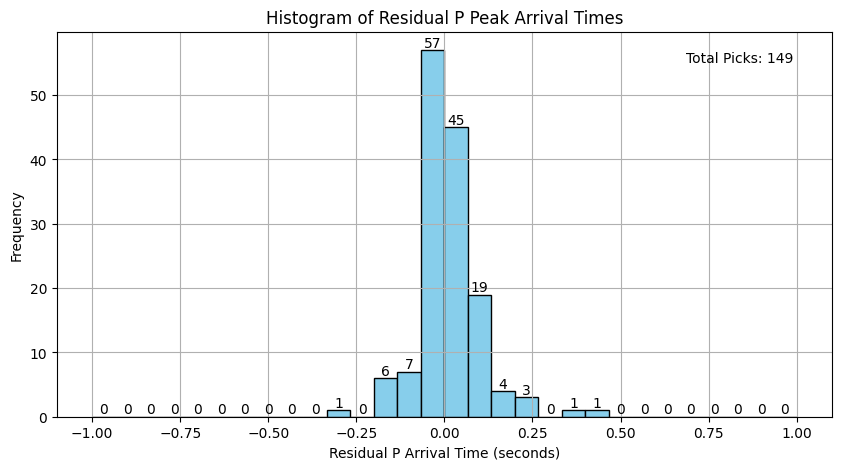

S-phase Residuals: Mean = 0.0298, Std = 0.2722
Total detected S picks: 146


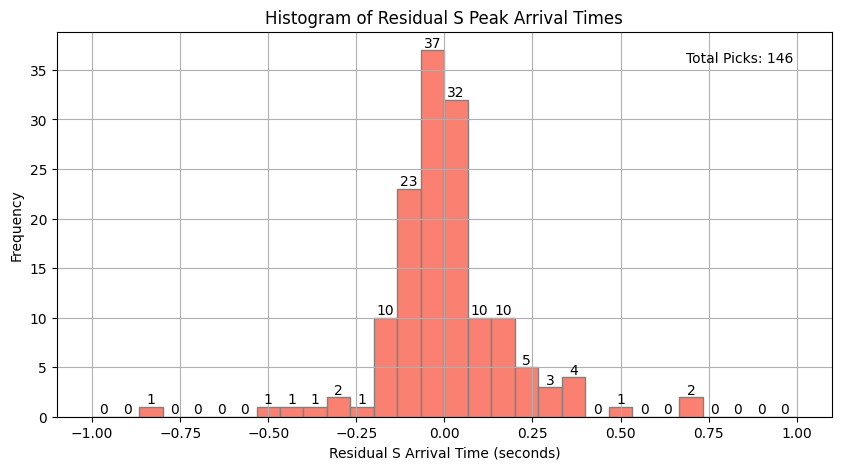

In [11]:
# Process samples
n_samples = 200
#n_samples = len(test_generator)

all_residual_p_arrival_times = []
all_residual_s_arrival_times = []

# Initialize counters for ground truth P and S labels
groundtruth_p_peaks = 0
groundtruth_s_peaks = 0

# Initialize counters for residuals smaller than 0.6 (absolute value)
count_residuals_p_under_0_6 = 0
count_residuals_s_under_0_6 = 0

for i in range(n_samples):
    sample = test_generator[np.random.randint(len(test_generator))]

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Update the counters
    groundtruth_p_peaks += len(y_p_peaks)
    groundtruth_s_peaks += len(y_s_peaks)

    # Convert ground truth peak indices to time values
    sampling_rate = 100  # Samples per second (100 Hz)
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals for P and S peaks, keeping only the smallest one by absolute value
    for y_p_time in y_p_arrival_times:
        residual_p_arrival_times = p_arrival_times - y_p_time
        if len(residual_p_arrival_times) > 0:
            min_residual_p = residual_p_arrival_times[np.argmin(np.abs(residual_p_arrival_times))]
            all_residual_p_arrival_times.append(min_residual_p)
            if np.abs(min_residual_p) < 0.6:
                count_residuals_p_under_0_6 += 1
        
    for y_s_time in y_s_arrival_times:
        residual_s_arrival_times = s_arrival_times - y_s_time
        if len(residual_s_arrival_times) > 0:
            min_residual_s = residual_s_arrival_times[np.argmin(np.abs(residual_s_arrival_times))]
            all_residual_s_arrival_times.append(min_residual_s)
            if np.abs(min_residual_s) < 0.6:
                count_residuals_s_under_0_6 += 1

# Display the total counts of ground truth P and S peaks
print(f"Total ground truth P peaks: {groundtruth_p_peaks}")
print(f"Total ground truth S peaks: {groundtruth_s_peaks}")

# Display the counts of residuals under 0.6 seconds
print(f"Total P-phase residuals under 0.6s: {count_residuals_p_under_0_6}")
print(f"Total S-phase residuals under 0.6s: {count_residuals_s_under_0_6}")

# Plot the histogram of residual P peak arrival times
plt.figure(figsize=(10, 5))
counts_p, bins_p, patches_p = plt.hist(all_residual_p_arrival_times, bins=30, color='skyblue', edgecolor='black', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_p, bins_p, patches_p):
    plt.text(bin_ + (bins_p[1] - bins_p[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_p = len(all_residual_p_arrival_times)
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_p}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"P-phase Residuals: Mean = {mean_p:.4f}, Std = {std_p:.4f}")
print(f"Total detected P picks: {total_picks_p}")

plt.title('Histogram of Residual P Peak Arrival Times')
plt.xlabel('Residual P Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
#plt.savefig("residual_p_histogram.png")  # Save the figure as a PNG file
plt.show()

# Plot the histogram of residual S peak arrival times
plt.figure(figsize=(10, 5))
counts_s, bins_s, patches_s = plt.hist(all_residual_s_arrival_times, bins=30, color='salmon', edgecolor='grey', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_s, bins_s, patches_s):
    plt.text(bin_ + (bins_s[1] - bins_s[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_s = len(all_residual_s_arrival_times)
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_s}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"S-phase Residuals: Mean = {mean_s:.4f}, Std = {std_s:.4f}")
print(f"Total detected S picks: {total_picks_s}")

plt.title('Histogram of Residual S Peak Arrival Times')
plt.xlabel('Residual S Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
#plt.savefig("residual_s_histogram.png")  # Save the figure as a PNG file
plt.show()

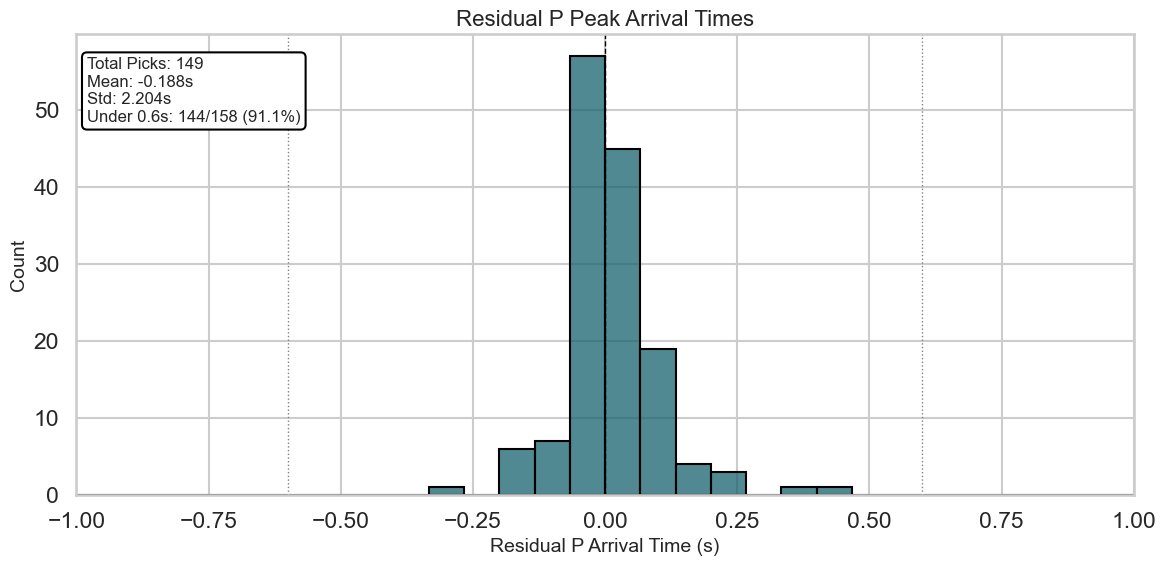

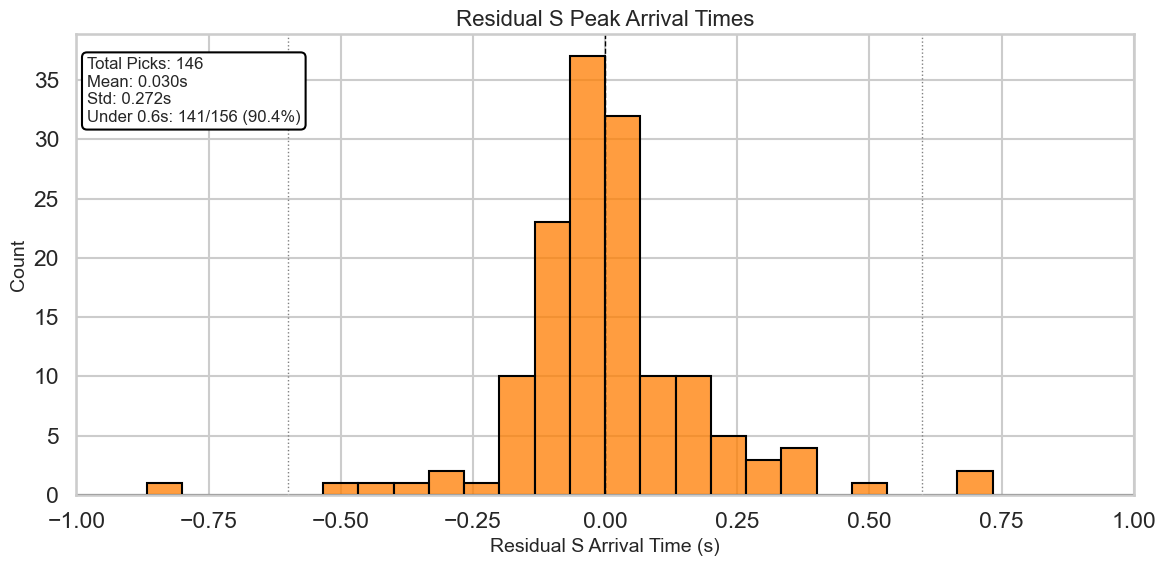

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seaborn style
sns.set(style="whitegrid", context="talk")

# Parameters
x_min, x_max = -1, 1
bins = np.linspace(x_min, x_max, 31)  # 30 bins between -1 and 1

# Custom colors
p_color = '#15616d'
s_color = '#ff7d00'

# === P-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_p_arrival_times, bins=bins, kde=False, color=p_color, edgecolor='black', stat='count')

# Vertical lines at 0s and ±0.6s
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
total_picks_p = len(all_residual_p_arrival_times)
fraction_p = count_residuals_p_under_0_6 / groundtruth_p_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_p}\nMean: {mean_p:.3f}s\nStd: {std_p:.3f}s\nUnder 0.6s: {count_residuals_p_under_0_6}/{groundtruth_p_peaks} ({fraction_p:.1%})',
         ha='left', va='top', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual P Peak Arrival Times', fontsize=16)
plt.xlabel('Residual P Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.tight_layout()
#plt.savefig("residual_p_histogram_final.png")
#plt.savefig("residual_p_histogram_final.ps")
plt.show()


# === S-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_s_arrival_times, bins=bins, kde=False, color=s_color, edgecolor='black', stat='count')

# Vertical lines at 0s and ±0.6s
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
total_picks_s = len(all_residual_s_arrival_times)
fraction_s = count_residuals_s_under_0_6 / groundtruth_s_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_s}\nMean: {mean_s:.3f}s\nStd: {std_s:.3f}s\nUnder 0.6s: {count_residuals_s_under_0_6}/{groundtruth_s_peaks} ({fraction_s:.1%})',
         ha='left', va='top', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual S Peak Arrival Times', fontsize=16)
plt.xlabel('Residual S Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.tight_layout()
#plt.savefig("residual_s_histogram_final.png")
#plt.savefig("residual_s_histogram_final.ps")
plt.show()

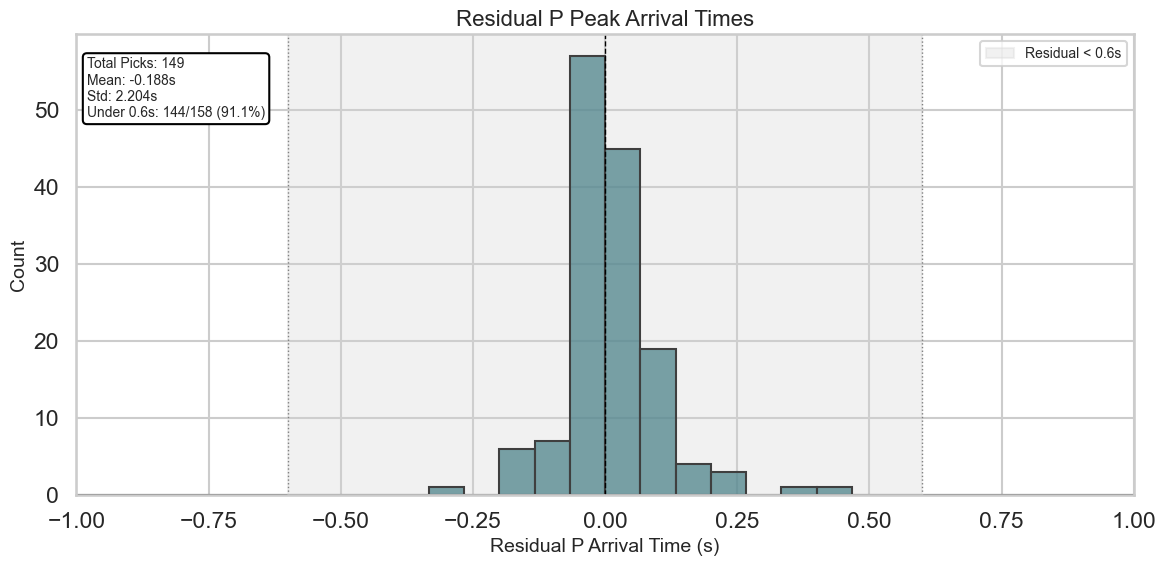

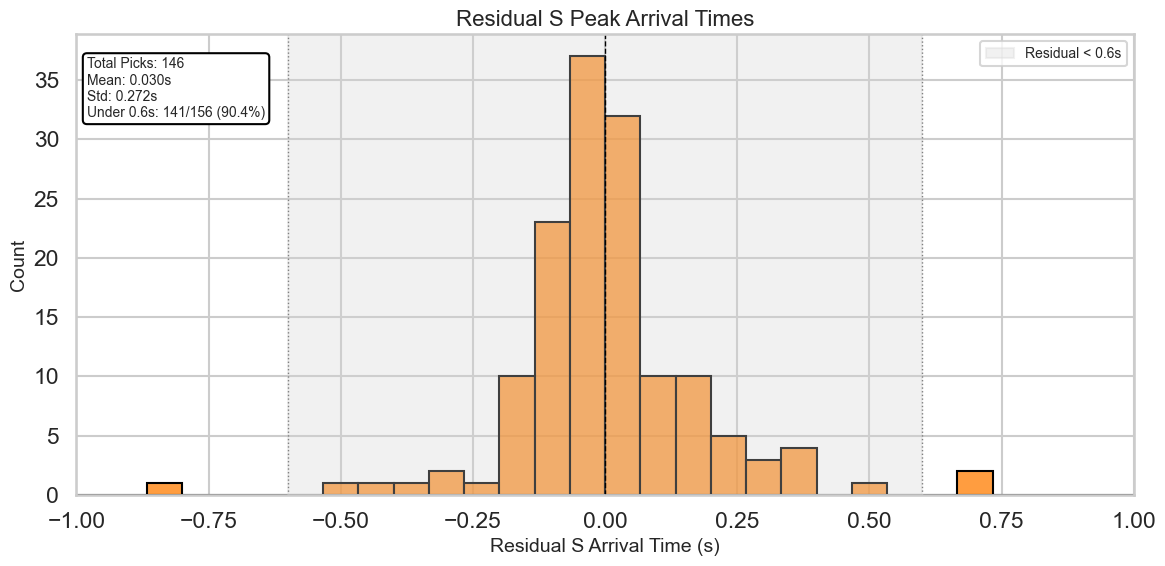

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seaborn style
sns.set(style="whitegrid", context="talk")

# Parameters
x_min, x_max = -1, 1
bins = np.linspace(x_min, x_max, 31)  # 30 bins between -1 and 1

# Custom colors
p_color = '#15616d'
s_color = '#ff7d00'
shading_color = '#d3d3d3'  # light gray for shaded success zone

# === P-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_p_arrival_times, bins=bins, kde=False, color=p_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
total_picks_p = len(all_residual_p_arrival_times)
fraction_p = count_residuals_p_under_0_6 / groundtruth_p_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_p}\nMean: {mean_p:.3f}s\nStd: {std_p:.3f}s\nUnder 0.6s: {count_residuals_p_under_0_6}/{groundtruth_p_peaks} ({fraction_p:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual P Peak Arrival Times', fontsize=16)
plt.xlabel('Residual P Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
#plt.savefig("residual_p_histogram_shaded.png")
#plt.savefig("residual_p_histogram_shaded.ps")
plt.show()


# === S-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_s_arrival_times, bins=bins, kde=False, color=s_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
total_picks_s = len(all_residual_s_arrival_times)
fraction_s = count_residuals_s_under_0_6 / groundtruth_s_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_s}\nMean: {mean_s:.3f}s\nStd: {std_s:.3f}s\nUnder 0.6s: {count_residuals_s_under_0_6}/{groundtruth_s_peaks} ({fraction_s:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual S Peak Arrival Times', fontsize=16)
plt.xlabel('Residual S Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
#plt.savefig("residual_s_histogram_shaded.png")
#plt.savefig("residual_s_histogram_shaded.ps")
plt.show()
